## Load and Prep

In [406]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib as mpl
from collections import Counter
from scipy import stats
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels.stats.weightstats
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.expand_frame_repr', False) #expands columns in pandas removing truncation


#  load df
df = pd.read_csv(r'C:\Users\jason\Desktop\vgsales.csv')
col_names = df.columns


# Remove unwanted columns
df = df[['Name', 'Platform', 'Genre', 'Publisher', 'Developer', 'Global_Sales', 'NA_Sales', 'PAL_Sales', 'JP_Sales', 'Other_Sales', 'Release_Date']]

# import ign df with scores
ign = pd.read_csv(r'C:\Users\jason\Desktop\ign.csv')
#from dropbox
#ign = pd.read_csv('https://www.dropbox.com/s/glkqvg2g0baxeaf/ign.csv?dl=1')

ign = ign[['title', 'platform', 'score', 'editors_choice', 'release_year', 'release_month', 'release_day']]

# Rename date columns to capital for consistency
ign.rename(columns={'release_year': 'Release_Year', 'release_month': 'Release_Month', 'release_day': 'Release_Day'},
           inplace=True)


# Fix platform data in ign so it matches that in games df
consoles_ign = ['NES', 'Super NES', 'Nintendo 64', 'GameCube', 'Wii', 'Wii U', 'NS', 'Game Boy', 'Game Boy Color',
                'Game Boy Advance', 'Game Gear', 'Nintendo DS', 'Nintendo 3DS', 'PlayStation', 'PlayStation 2', 'PlayStation 3',
                'PlayStation 4', 'PlayStation Portable', 'PlayStation Vita', 'Xbox', 'Xbox 360', 'Xbox One', 'Genesis', 'Dreamcast']

consoles_games = ['NES', 'SNES', 'N64', 'GC', 'Wii', 'WiiU', 'NS', 'GB', 'GBC', 'GBA', 'GG', 'DS', '3DS', 'PS', 'PS2',
            'PS3', 'PS4', 'PSP', 'PSV', 'XB', 'X360', 'XOne', 'GEN', 'DC']

ign = ign.replace(to_replace=consoles_ign, value=consoles_games)


# ~~~~~~~~~PLATFORM~~~~~~~~~~
# Looking at the different types of Platforms to remove unnecessary ones (nobody cares about the commodore 64 from '85)
df.Platform.value_counts(dropna=False)

consoles = ['NES', 'SNES', 'N64', 'GC', 'Wii', 'WiiU', 'NS', 'GB', 'GBA', 'GBC', 'GG', 'DS', '3DS', 'PS', 'PS2',
            'PS3', 'PS4', 'PSP', 'PSV', 'XB', 'X360', 'XOne', 'GEN', 'DC']

# Removes all rows NOT associated with the above consoles and makes new db, games, by merging
vgsales = df[df['Platform'].isin(consoles)]
ign = ign[ign['platform'].isin(consoles)]


# join the two dfs based on game name (and add platform)
games = pd.merge(vgsales, ign, left_on=['Name', 'Platform'], right_on=['title', 'platform'], how='left')




# Fixing Sales columns (removing m)
games.Global_Sales = games.Global_Sales.str.replace('m', '')
games.NA_Sales = games.NA_Sales.str.replace('m', '')
games.PAL_Sales = games.PAL_Sales.str.replace('m', '')
games.JP_Sales = games.JP_Sales.str.replace('m', '')
games.Other_Sales = games.Other_Sales.str.replace('m', '')

# Splitting Release_Date into Day/Month/Year
games['Day'] = games.Release_Date.str[0:2]
games['Month'] = games.Release_Date.str[5:8]
games['Year'] = games.Release_Date.str[9:]

# Converting to appropriate data types
games.Genre = games.Genre.astype('category')
games.Name = games.Name.astype('str')
games.Platform = games.Platform.astype('category')
games.Publisher = games.Publisher.astype('category')
games.Developer = games.Developer.astype('category')
games.Global_Sales = games.Global_Sales.astype('float')
games.NA_Sales = games.NA_Sales.astype('float')
games.PAL_Sales = games.PAL_Sales.astype('float')
games.JP_Sales = games.JP_Sales.astype('float')
games.Other_Sales = games.Other_Sales.astype('float')
games.title = games.title.astype('str')
games.platform = games.platform.astype('category')
games.editors_choice = games.editors_choice.astype('category')


# Converting to Datetime
games.Release_Date = games.Month + '/' + games.Day + '/' + games.Year.astype('str') #combine to single column
games.Release_Date = [None if pd.isnull(dates) else datetime.strptime(str(dates), '%b/%d/%y') for dates in games.Release_Date]

# Remove titles with 1970 release dates (wrong)
games = games[games['Release_Date'].dt.year >= 1980]


# Fixing titles discovered incorrect dates
games.loc[[21278], 'Release_Date'] = games.loc[21278, 'Release_Date'].replace(2003)
games.loc[[2232], 'Release_Date'] = games.loc[2232, 'Release_Date'].replace(2010)
games.loc[[11572], 'Release_Date'] = games.loc[11572, 'Release_Date'].replace(2007)
games.loc[[17935], 'Release_Date'] = games.loc[17935, 'Release_Date'].replace(2008)
games.loc[[25883], 'Release_Date'] = games.loc[25883, 'Release_Date'].replace(2009)
games.loc[[15941], 'Release_Date'] = games.loc[15941, 'Release_Date'].replace(2006)
games.loc[[22295], 'Release_Date'] = games.loc[22295, 'Release_Date'].replace(2007)
games.loc[[1005], 'Release_Date'] = games.loc[1005, 'Release_Date'].replace(2012)
games.loc[[1751], 'Release_Date'] = games.loc[1751, 'Release_Date'].replace(2009)
games.loc[[10413], 'Release_Date'] = games.loc[10413, 'Release_Date'].replace(2013)
games.loc[[19837], 'Release_Date'] = games.loc[19837, 'Release_Date'].replace(2006)
games.loc[[21229], 'Release_Date'] = games.loc[21229, 'Release_Date'].replace(2011)
games.loc[[21763], 'Release_Date'] = games.loc[21763, 'Release_Date'].replace(2011)
games.loc[[2012], 'Release_Date'] = games.loc[2012, 'Release_Date'].replace(2011)
games.loc[[11368], 'Release_Date'] = games.loc[11368, 'Release_Date'].replace(2014)
games.loc[[5363], 'Release_Date'] = games.loc[5363, 'Release_Date'].replace(2000)
games.loc[[6033], 'Release_Date'] = games.loc[6033, 'Release_Date'].replace(2001)
games.loc[[6033], 'Release_Date'] = games.loc[6033, 'Release_Date'].replace(2001)



# Find other titles with improper release and no info, as discovered (never released, cancelled, etc)
begin = [1983, 1990, 1996, 2001, 2006, 2012, 2017, 1989, 2001, 1998, 1990, 2004, 2011, 1994, 2000,
            2006, 2013, 2005, 2011, 2001, 2005, 2013, 1988, 1998]
end = [1995, 1999, 2002, 2007, 2017, 2018, 2020, 2003, 2008, 2003, 1997, 2016, 2020, 2006, 2013,
            2017, 2020, 2016, 2020, 2009, 2017, 2020, 1999, 2001]
life = [j - i for i, j in zip(begin, end)]


systems_info = pd.DataFrame({'Consoles': consoles,
                             'Start': begin,
                             'Discontinued': end,
                             'Lifespan': life})

systems_info = systems_info.sort_values('Start')
systems_info = systems_info.reset_index(inplace=False)
systems_info = systems_info.drop('index', axis=1)



# Create General categories Nintendo, Sony, Microsoft etc
company = [] # initialize a list

# List of platforms to define each company
Nintendo = ['NES', 'SNES', 'N64', 'GC', 'Wii', 'WiiU', 'NS', 'GB', 'GBA', 'GBC', 'DS', '3DS']
Microsoft = ['XB', 'X360', 'XOne']
Sony = ['PS', 'PS2', 'PS3', 'PS4', 'PSP', 'PSV']
Sega = ['GEN', 'DC', 'GG']


# Loop over platforms to fill company list up and add it to games df
for i in games.Platform:
    if i in Sony:
        company.append('Sony')
    elif i in Nintendo:
        company.append('Nintendo')
    elif i in Microsoft:
        company.append('Microsoft')
    else:
        company.append('Sega')

games['Company'] = company




# Create df's for each system with erroneous dates to fix as needed
bad_NES = games.loc[((games['Release_Date'].dt.year < begin[0]) | (games['Release_Date'].dt.year > end[0]))
                      & (games['Platform'] == consoles[0])]
bad_SNES = games.loc[((games['Release_Date'].dt.year < begin[1]) | (games['Release_Date'].dt.year > end[1]))
                      & (games['Platform'] == consoles[1])]
bad_N64 = games.loc[((games['Release_Date'].dt.year < begin[2]) | (games['Release_Date'].dt.year > end[2]))
                      & (games['Platform'] == consoles[2])]
bad_GC = games.loc[((games['Release_Date'].dt.year < begin[3]) | (games['Release_Date'].dt.year > end[3]))
                      & (games['Platform'] == consoles[3])]
bad_Wii = games.loc[((games['Release_Date'].dt.year < begin[4]) | (games['Release_Date'].dt.year > end[4]))
                      & (games['Platform'] == consoles[4])]
bad_WiiU = games.loc[((games['Release_Date'].dt.year < begin[5]) | (games['Release_Date'].dt.year > end[5]))
                      & (games['Platform'] == consoles[5])]
bad_NS = games.loc[((games['Release_Date'].dt.year < begin[6]) | (games['Release_Date'].dt.year > end[6]))
                      & (games['Platform'] == consoles[6])]
bad_GB = games.loc[((games['Release_Date'].dt.year < begin[7]) | (games['Release_Date'].dt.year > end[7]))
                      & (games['Platform'] == consoles[7])]
bad_GBA = games.loc[((games['Release_Date'].dt.year < begin[8]) | (games['Release_Date'].dt.year > end[8]))
                      & (games['Platform'] == consoles[8])]
bad_GBC = games.loc[((games['Release_Date'].dt.year < begin[9]) | (games['Release_Date'].dt.year > end[9]))
                      & (games['Platform'] == consoles[9])]
bad_GG = games.loc[((games['Release_Date'].dt.year < begin[10]) | (games['Release_Date'].dt.year > end[10]))
                      & (games['Platform'] == consoles[10])]
bad_DS = games.loc[((games['Release_Date'].dt.year < begin[11]) | (games['Release_Date'].dt.year > end[11]))
                      & (games['Platform'] == consoles[11])]
bad_3DS = games.loc[((games['Release_Date'].dt.year < begin[12]) | (games['Release_Date'].dt.year > end[12]))
                      & (games['Platform'] == consoles[12])]
bad_PS = games.loc[((games['Release_Date'].dt.year < begin[13]) | (games['Release_Date'].dt.year > end[13]))
                      & (games['Platform'] == consoles[13])]
bad_PS2 = games.loc[((games['Release_Date'].dt.year < begin[14]) | (games['Release_Date'].dt.year > end[14]))
                      & (games['Platform'] == consoles[14])]
bad_PS3 = games.loc[((games['Release_Date'].dt.year < begin[15]) | (games['Release_Date'].dt.year > end[15]))
                      & (games['Platform'] == consoles[15])]
bad_PS4 = games.loc[((games['Release_Date'].dt.year < begin[16]) | (games['Release_Date'].dt.year > end[16]))
                      & (games['Platform'] == consoles[16])]
bad_PSP = games.loc[((games['Release_Date'].dt.year < begin[7]) | (games['Release_Date'].dt.year > end[17]))
                      & (games['Platform'] == consoles[17])]
bad_PSV = games.loc[((games['Release_Date'].dt.year < begin[18]) | (games['Release_Date'].dt.year > end[18]))
                      & (games['Platform'] == consoles[18])]
bad_XB = games.loc[((games['Release_Date'].dt.year < begin[19]) | (games['Release_Date'].dt.year > end[19]))
                      & (games['Platform'] == consoles[19])]
bad_X360 = games.loc[((games['Release_Date'].dt.year < begin[20]) | (games['Release_Date'].dt.year > end[20]))
                      & (games['Platform'] == consoles[20])]
bad_XOne = games.loc[((games['Release_Date'].dt.year < begin[21]) | (games['Release_Date'].dt.year > end[21]))
                      & (games['Platform'] == consoles[21])]
bad_GEN = games.loc[((games['Release_Date'].dt.year < begin[22]) | (games['Release_Date'].dt.year > end[22]))
                      & (games['Platform'] == consoles[22])]
bad_DC = games.loc[((games['Release_Date'].dt.year < begin[23]) | (games['Release_Date'].dt.year > end[23]))
                      & (games['Platform'] == consoles[23])]
bad_DC.drop(24721, inplace=True) # drop value that actually was released outside of release date so not removed below

# Fix the two missing values for developers
games[games['Developer'].isnull()]
games.loc[[10489], 'Developer'] = 'Ubisoft'
games.loc[[31225], 'Developer'] = 'Unknown'

# Drop games with no info and bad dates (assume never released) 246 games
games = games.drop(bad_NES.index.values)
games = games.drop(bad_SNES.index.values)
games = games.drop(bad_GC.index.values)
games = games.drop(bad_Wii.index.values)
games = games.drop(bad_WiiU.index.values)
games = games.drop(bad_GB.index.values)
games = games.drop(bad_GBA.index.values)
games = games.drop(bad_DS.index.values)
games = games.drop(bad_3DS.index.values)
games = games.drop(bad_PS.index.values)
games = games.drop(bad_PS2.index.values)
games = games.drop(bad_PS3.index.values)
games = games.drop(bad_PSP.index.values)
games = games.drop(bad_X360.index.values)
games = games.drop(bad_GEN.index.values)
games = games.drop(bad_DC.index.values)

# Drop all games missing global sales values pre 2018 (not games to predict)
todrop = games[games['Global_Sales'].isnull() & (games['Release_Date'].dt.year < 2018)]
games = games.drop(todrop.index)

# Drop Wii Sports since it was given with every wii
indexNames = games[games['Name']=='Wii Sports'].index
games.drop(indexNames, inplace=True)

# Clean up missing dates
games.Release_Year = games.Release_Date.dt.year
games.Release_Month = games.Release_Date.dt.month
games.Release_Day = games.Release_Date.dt.day


# Check on number of missing values
#games.isnull().sum()


# Assign a numeric value for the order of games' release to simulate time progression
games = games.sort_values(['Release_Date']) #.reset_index(drop=True)
games['Order'] = list(range(len(games)))
games = games.sort_index()

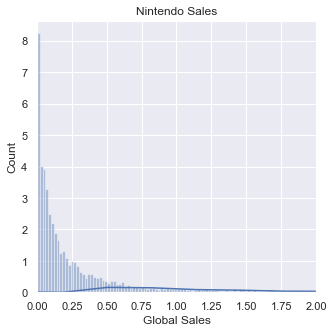

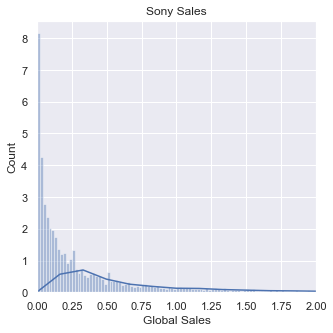

t = 0.178
p-value = 0.859
p-value much greater than alpha, so we cannot reject the null hypothesis and Nintendo did not make significantly more sales


In [407]:
# Quick simple hypothesis test:
# It appears like Nintendo sells better, is that true?

# H0: Nintendo based mean game sales is the same as Sony based mean game sales (μn = μs)
# Ha: Nintendo based mean game sales is  not the same as Sony based mean game sale (μn != μs)
# alpha = 0.05

nintendo = games[games['Company'] == 'Nintendo']
nintendo = nintendo.dropna(subset=['Global_Sales'])
sony = games[games['Company'] == 'Sony']
sony = sony.dropna(subset=['Global_Sales'])


# Histogram
sns.distplot(nintendo.Global_Sales, bins=2000)
plt.xlim(0, 2)
plt.xlabel('Global Sales')
plt.ylabel('Count')
plt.title('Nintendo Sales')
plt.show()

sns.distplot(sony.Global_Sales, bins=1000)
plt.xlim(0, 2)
plt.xlabel('Global Sales')
plt.ylabel('Count')
plt.title('Sony Sales')
plt.show()

hyp = statsmodels.stats.weightstats.ztest(nintendo.Global_Sales, sony.Global_Sales)
print('t =', round(hyp[0], 3))
print('p-value =', round(hyp[1], 3))
print('p-value much greater than alpha, so we cannot reject the null hypothesis and Nintendo did not make significantly more sales')

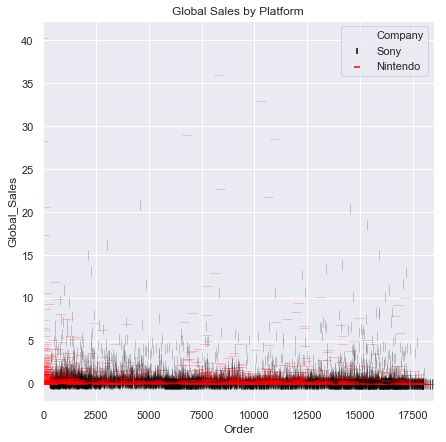

In [408]:
markers = {'Sony': '|', 'Nintendo': '_'}
colors = ["black", "red"]

fig=plt.figure(figsize=(7,7))
sns.scatterplot(comparison.Order, comparison.Global_Sales, hue=comparison.Company, alpha=0.25, 
                style=comparison.Company, markers=markers, palette=colors, s=100)

plt.xlim(0, max(comparison.Order))
plt.title('Global Sales by Platform');

Similarly, this graph shows the right-skew associated with the Glboal_Sales. It will be important to use log to adjust this to improve predictive performance.

## EDA

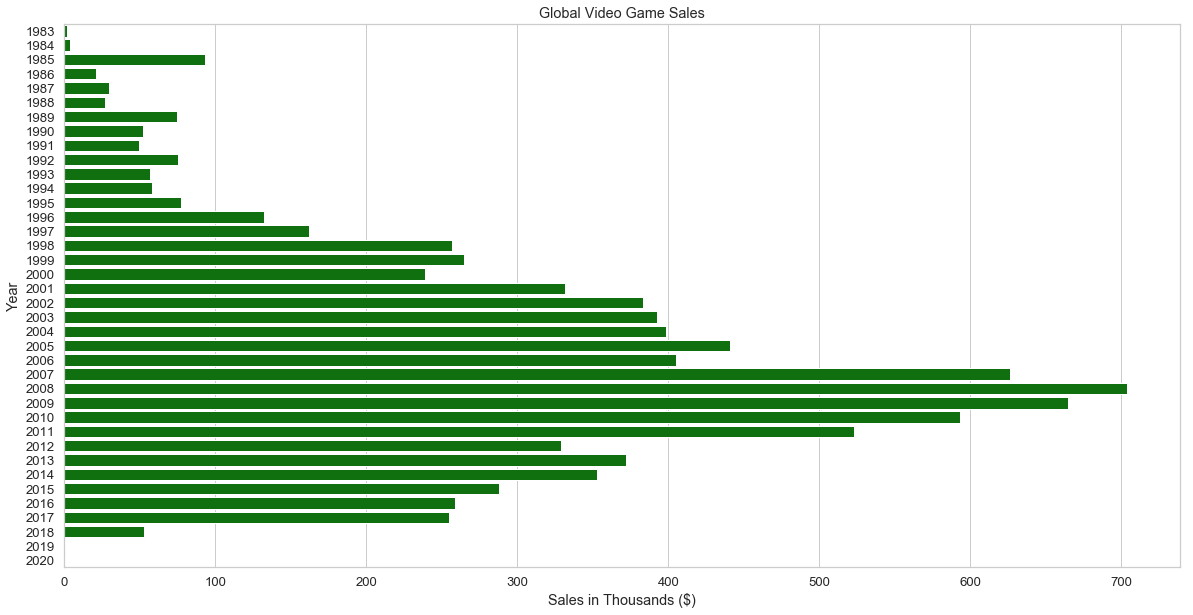

In [409]:
# game sales by year
by_year = games.groupby(by=games['Release_Date'].dt.year).sum()
by_year.reset_index(inplace=True)

fig = plt.figure(figsize=(20, 10))
sns.set(style='whitegrid', font_scale=1.2)
gsby = sns.barplot(x='Global_Sales', y='Release_Date', data=by_year, orient='h', color='green').set_title('Global Video Game Sales')
plt.xlabel('Sales in Thousands ($)')
plt.ylabel('Year')
plt.show()

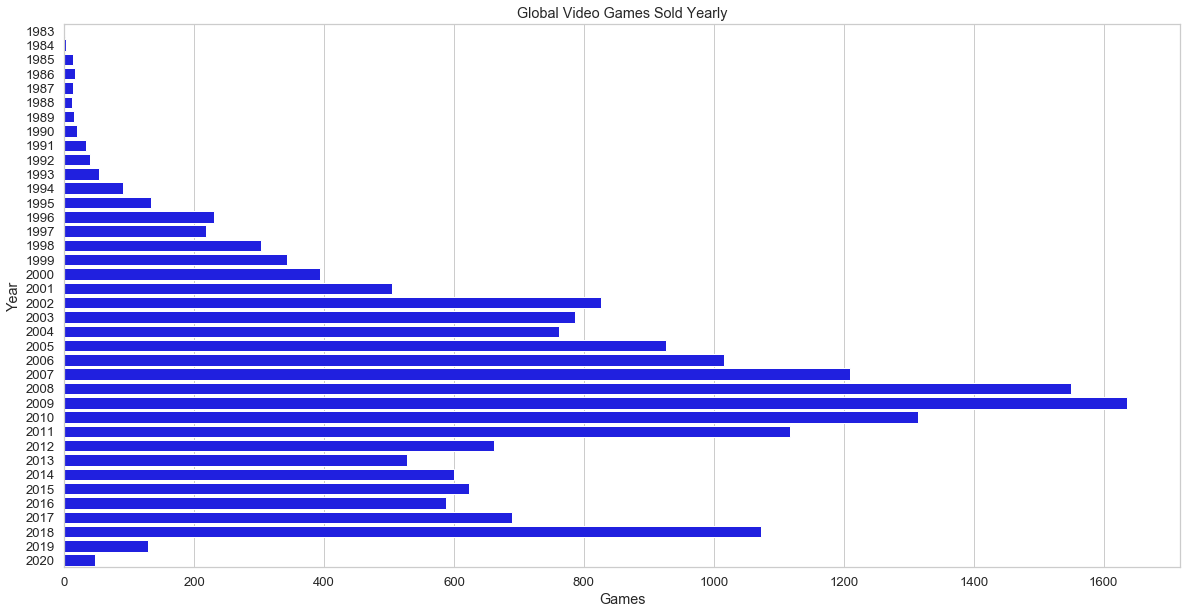

In [410]:
# number of games released each year
fig = plt.figure(figsize=(20, 10))
sns.set(style='whitegrid', font_scale=1.2)
gpy = sns.countplot(y=games['Release_Date'].dt.year, data=games, color='blue').set_title('Global Video Games Sold Yearly')
plt.xlabel('Games')
plt.ylabel('Year')
plt.show()

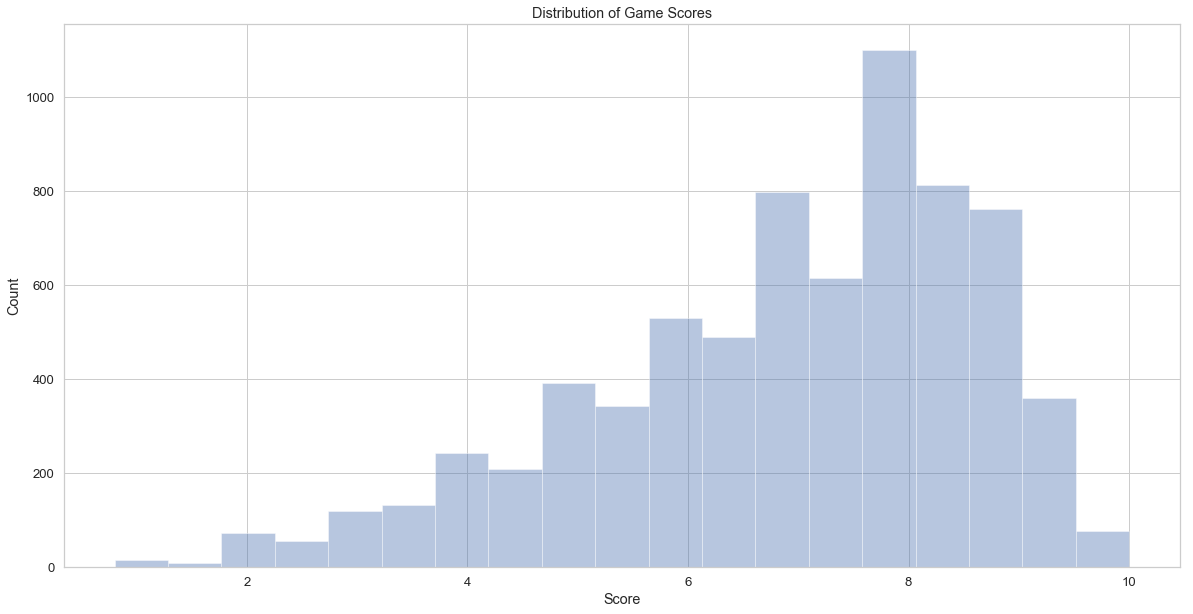

In [411]:
# histogram of game scores
fig = plt.figure(figsize=(20, 10))
scores = games[np.isfinite(games['score'])]  # 8k games
sns.distplot(scores.score, bins=19, kde=False).set_title('Distribution of Game Scores')
sns.set(style='ticks')
plt.ylabel('Count')
plt.xlabel('Score')
plt.show()

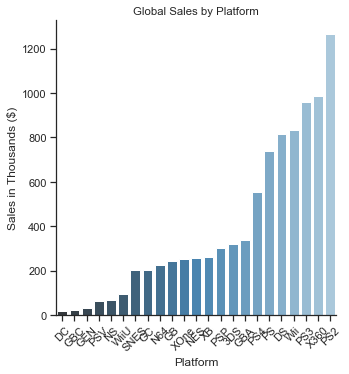

In [412]:
# Global Sales by Console
by_console = games.groupby(by='Platform').sum()
by_console.reset_index(inplace=True)
by_console = by_console[by_console['Platform'] != 'GG']
by_console = by_console.sort_values(['Global_Sales']).reset_index(drop=True)
order = by_console.Platform

gsbc = sns.catplot(x='Platform', y='Global_Sales', kind='bar', data=by_console, order=order, palette=('Blues_d'))
plt.xticks(rotation=45)
plt.ylabel('Sales in Thousands ($)')
sns.set(style='whitegrid', font_scale=0.95)
plt.title('Global Sales by Platform')
plt.show()

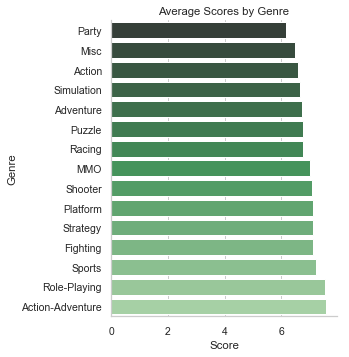

In [413]:
# Average score by genre
by_genre = games.groupby(by='Genre').mean()
by_genre.reset_index(inplace=True)
by_genre = by_genre.sort_values(['score']).reset_index(drop=True)
order = by_genre.Genre
order = order[0:15] # remove 0 categories

sns.catplot(y='Genre', x='score', data=by_genre, kind='bar', palette='Greens_d',
            order=order)
plt.xlabel('Score')
plt.title('Average Scores by Genre')
plt.show()
#can see that there is little change in avg score

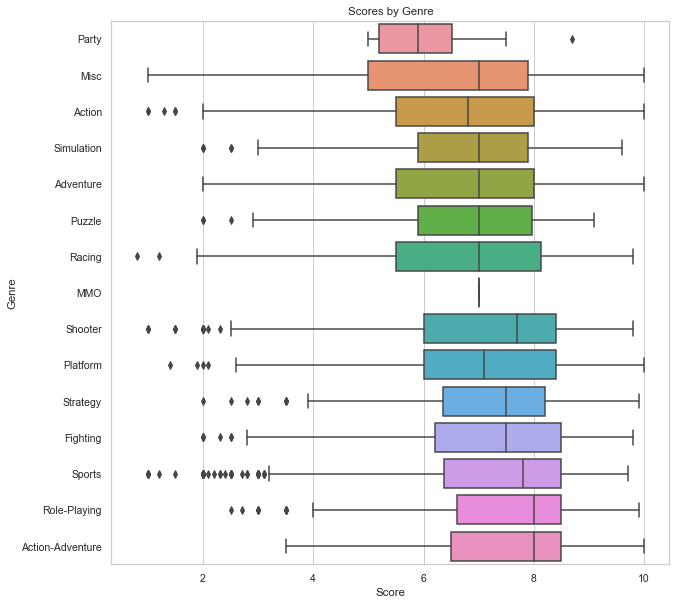

In [414]:
fig = plt.figure(figsize=(10, 10))
sns.boxplot(y='Genre', x='score', data=games, order=order)
plt.title('Scores by Genre')
plt.xlabel('Score')
plt.show()

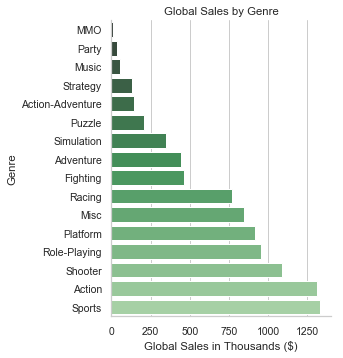

In [415]:
# Sales by genre
by_genre = games.groupby(by='Genre').sum()
by_genre.reset_index(inplace=True)
by_genre = by_genre.sort_values(['Global_Sales']).reset_index(drop=True)
order = by_genre.Genre
order = order[2:] # remove 2 0 categories

sns.catplot(y='Genre', x='Global_Sales', data=by_genre, kind='bar', order=order, palette=('Greens_d'))
plt.xlabel('Global Sales in Thousands ($)')
plt.title('Global Sales by Genre')
plt.show()

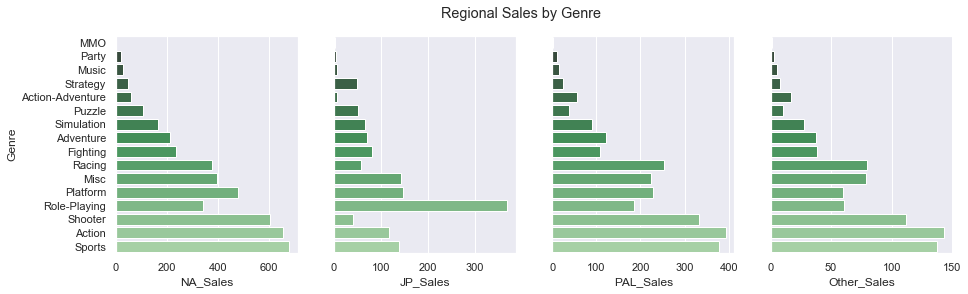

In [416]:
# By Region
sns.set(rc={'figure.figsize':(15,4)})


f, axes = plt.subplots(1, 4, sharey=True)
ax1 = sns.barplot(y='Genre', x='NA_Sales', data=by_genre, order=order, palette=('Greens_d'), ax=axes[0])
ax2 = sns.barplot(y='Genre', x='JP_Sales', data=by_genre, order=order, palette=('Greens_d'), ax=axes[1])
ax3 = sns.barplot(y='Genre', x='PAL_Sales', data=by_genre, order=order, palette=('Greens_d'), ax=axes[2])
ax4 = sns.barplot(y='Genre', x='Other_Sales', data=by_genre, order=order, palette=('Greens_d'), ax=axes[3])
ax1.set_ylabel('Genre')
ax2.set_ylabel('')
ax3.set_ylabel('')
ax4.set_ylabel('')
f.suptitle('Regional Sales by Genre');

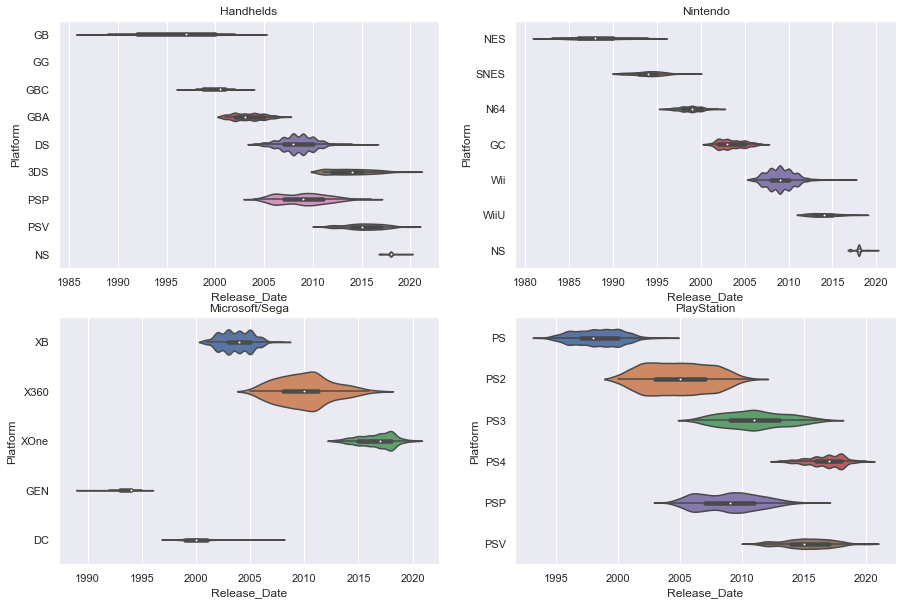

In [417]:
# Year vs Platform by type/group
handheld_systems = ['GB', 'GG', 'GBC', 'GBA', 'DS', '3DS', 'PSP', 'PSV', 'NS']
nintendo_systems = ['NES', 'SNES', 'N64', 'GC', 'Wii', 'WiiU', 'NS']
microsoft_systems = ['XB', 'X360', 'XOne', 'GEN', 'DC']
ps_systems = ['PS', 'PS2', 'PS3', 'PS4', 'PSP', 'PSV']
early_consoles = ['NES', 'SNES', 'GEN', 'PS', 'N64', 'DC']
advanced_consoles = ['PS2', 'GC', 'XB', 'PSP', 'DS', 'X360', 'PS3', 'Wii', 'XOne', 'PS4', 'NS']

handhelds = games[games['Platform'].isin(handheld_systems)]
nintendo = games[games['Platform'].isin(nintendo_systems)]
microsoft = games[games['Platform'].isin(microsoft_systems)]
playstation = games[games['Platform'].isin(ps_systems)]
earlygen = games[games['Platform'].isin(early_consoles)]
advancedgen = games[games['Platform'].isin(advanced_consoles)]

sns.set(style='whitegrid')
sns.set(rc={'figure.figsize':(15,10)})
fig, axes = plt.subplots(2, 2)
plt1 = sns.violinplot(x=handhelds['Release_Date'].dt.year, y='Platform', data=handhelds, scale='count', order=handheld_systems, ax=axes[0][0]).set_title('Handhelds')
plt2 = sns.violinplot(x=nintendo['Release_Date'].dt.year, y='Platform', data=nintendo, scale='count', order=nintendo_systems, ax=axes[0][1]).set_title('Nintendo')
plt3 = sns.violinplot(x=microsoft['Release_Date'].dt.year, y='Platform', data=microsoft, scale='count', order=microsoft_systems, ax=axes[1][0]).set_title('Microsoft/Sega')
plt4 = sns.violinplot(x=playstation['Release_Date'].dt.year, y='Platform', data=playstation, scale='count', order=ps_systems, ax=axes[1][1]).set_title('PlayStation')

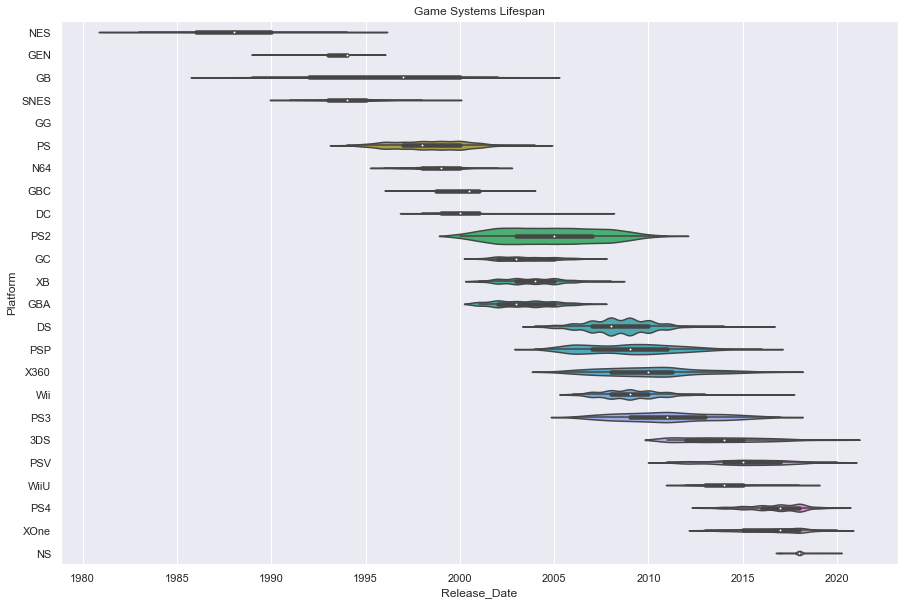

In [418]:
# earlygenplot = sns.violinplot(x=earlygen['Release_Date'].dt.year, y='Platform', data=earlygen, scale='count', order=early_consoles, inner='stick')
# advancedgenplot = sns.violinplot(x=advancedgen['Release_Date'].dt.year, y='Platform', data=advancedgen, palette='Set1', scale='count', order=advanced_consoles)

fig, ax = plt.subplots(figsize=(15,10))
plt.title('Game Systems Lifespan')
allplot = sns.violinplot(x=games['Release_Date'].dt.year, y='Platform', data=games, scale='count', order=systems_info.Consoles)

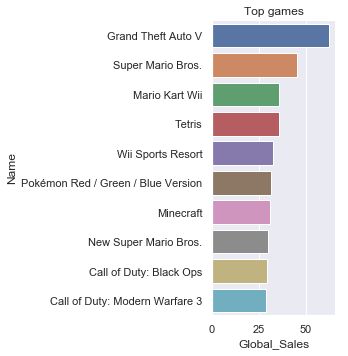

In [419]:
colnames = games.columns

def top_ten(DF, platforms):
    "This gets the top ten games in sales by region for each platform in a list and makes a new df"
    top_sellers = pd.DataFrame(columns=colnames)
    for item in platforms:
        X = DF[DF['Platform'].isin([item])]
        XNA = X.sort_values(by='NA_Sales', ascending=False).head(10)
        XPAL = X.sort_values(by='PAL_Sales', ascending=False).head(10)
        XJP = X.sort_values(by='JP_Sales', ascending=False).head(10)
        XOther = X.sort_values(by='Other_Sales', ascending=False).head(10)

        Y = pd.concat([XNA, XPAL])
        Z = pd.concat([XJP, XOther])
        combined = pd.concat([Y, Z])

        top_sellers = pd.concat([top_sellers, combined])

    return top_sellers


top_games = top_ten(games, consoles)

# Top games globally
top_sellers = games.groupby(by='Name').sum()
top_sellers = top_sellers.sort_values(by='Global_Sales', ascending=False).head(10)
top_sellers = top_sellers.reset_index(inplace=False)
#top_sellers = top_sellers.reset_index(inplace=True)
sns.catplot(x='Global_Sales', y='Name', kind='bar', data=top_sellers)
plt.title('Top games')
plt.show()

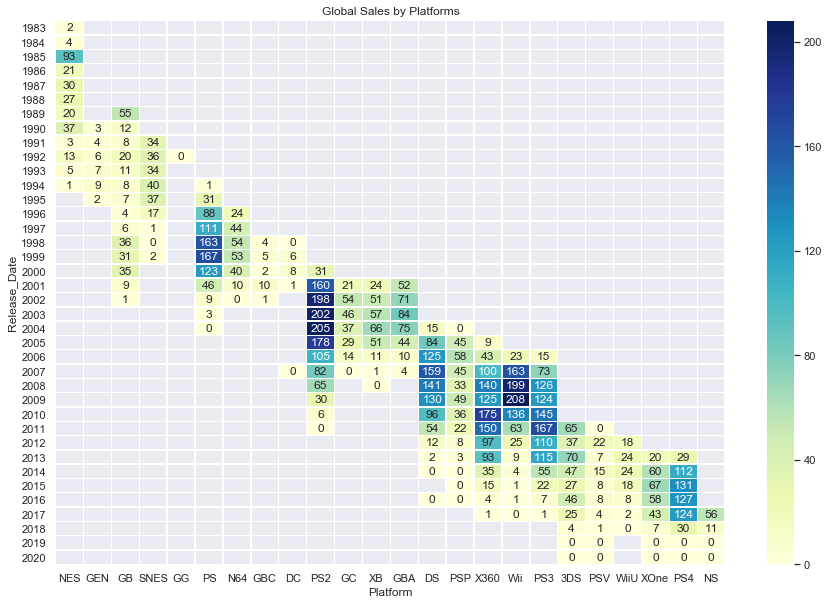

In [420]:
# average global sales per year by platform
plt.subplots(figsize=(15, 10))
test = games.groupby('Platform')['Platform'].count()
test.sort_values(ascending=True, inplace=True)
mean_test = games[games['Platform'].isin(test.index)]
abc = mean_test.groupby([mean_test['Release_Date'].dt.year, 'Platform'])['Global_Sales'].sum().reset_index()

abc = abc.pivot('Release_Date', 'Platform', 'Global_Sales')
abc = abc[['NES', 'GEN', 'GB', 'SNES', 'GG', 'PS', 'N64', 'GBC', 'DC', 'PS2', 'GC', 'XB',
                                                   'GBA', 'DS', 'PSP', 'X360', 'Wii', 'PS3', '3DS', 'PSV', 'WiiU',
                                                   'XOne', 'PS4', 'NS']]
abc = np.round(abc, decimals=0)  # remove decimals to avoid scientific notation
sns.heatmap(abc, annot=True, cmap='YlGnBu', linewidths=0.4, fmt='g')
plt.title('Global Sales by Platforms')
plt.yticks(rotation=0)
plt.show()

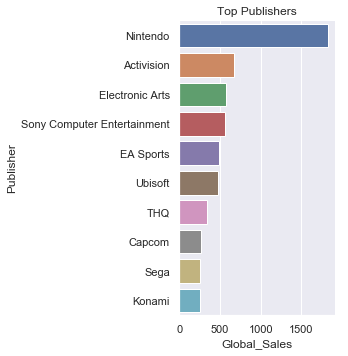

In [421]:
# Top Publishers
top_pub = games.groupby('Publisher').sum()
top_pub = top_pub.sort_values('Global_Sales', ascending=False).head(10)
top_pub = top_pub.reset_index(drop=False)
ord = list(top_pub.Publisher.head(10))
sns.catplot(x='Global_Sales', y='Publisher', data=top_pub, kind='bar', order=ord)
plt.title('Top Publishers')
plt.show()

In [422]:
# publishers by sales/game
game_count = ([1048, 1089, 836, 910, 609, 1089, 863, 726, 1203, 1258])
se = pd.Series(game_count)
top_pub['Game_Count'] = se.values
ppg = top_pub['Global_Sales']/top_pub['Game_Count']
top_pub['SPG'] = ppg.values

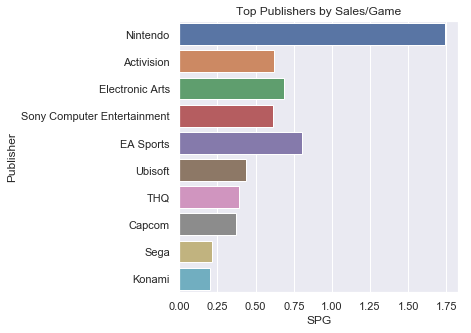

In [423]:
sns.set(rc={'figure.figsize':(5,5)})
plt.title('Top Publishers by Sales/Game')
sns.barplot(x='SPG', y='Publisher', data=top_pub, order=ord);

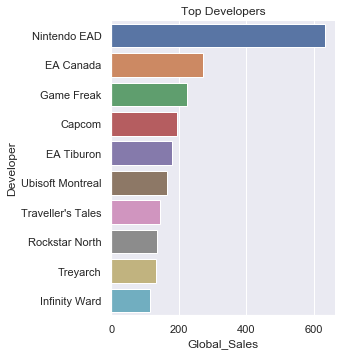

In [424]:
# Top Developers
top_dev = games.groupby('Developer').sum()
top_dev = top_dev.sort_values('Global_Sales', ascending=False).head(10)
top_dev = top_dev.reset_index(drop=False)
ord = list(top_dev.Developer.head(10))
sns.catplot(x='Global_Sales', y='Developer', data=top_dev, kind='bar', order=ord)
plt.title('Top Developers')
plt.show()

## Feature Engineering

In [425]:
# Create Handheld category
handheld_systems # ['GB', 'GG', 'GBC', 'GBA', 'DS', '3DS', 'PSP', 'PSV', 'NS']
games['Handheld'] = ["No" if i not in handheld_systems else "Yes" for i in games['Platform']]

In [426]:
# Create Focus_Region based on sales volume
games['Regional_Sales'] = 'Similar' #initialize all as ~ similar, then adjust for each group
games.loc[games['NA_Sales'] >= 0.50*games['Global_Sales'], 'Regional_Sales'] = 'NA' 
games.loc[games['JP_Sales'] >= 0.50*games['Global_Sales'], 'Regional_Sales'] = 'JP' 
games.loc[games['PAL_Sales'] >= 0.50*games['Global_Sales'], 'Regional_Sales'] = 'PAL' 
games.loc[games['Other_Sales'] >= 0.50*games['Global_Sales'], 'Regional_Sales'] = 'Other'
games.loc[games['Global_Sales'] == 0, 'Regional_Sales'] = 'None' # find way to adjust this, as it becomes a critical variable

## Model Prep

In [427]:
# Prepare model

# drop unnecessary columns for predicting
clean_df = games.drop(['title', 'platform', 'Day', 'NA_Sales', 'PAL_Sales', 'JP_Sales', 'Other_Sales', 'score', 'editors_choice', 'Year'], axis=1)

# clean up developer and reduce any company with fewer than specified counts re-assigned as: Indie
top_devs = clean_df.Developer.value_counts()
top_devs = top_devs.reset_index(drop=False)
top_devs.columns = ['Developer', 'Games']
indie_devs = top_devs[top_devs['Games'] < 10]  # Reduce list to only devs with < 10 games
indie_devs = list(indie_devs.Developer)  # (list of 3825 names changing to Indie)


clean_df.Developer = clean_df.Developer.cat.add_categories(['Indie'])  # Add new category for dev column
clean_df.loc[clean_df['Developer'].isin(indie_devs), "Developer"] = 'Indie'  # Change appropriate entries




# Publisher
top_pubs = clean_df.Publisher.value_counts()
top_pubs = top_pubs.reset_index(drop=False)
top_pubs.columns = ['Publisher', 'Games']
indie_pubs = top_pubs[top_pubs['Games'] < 10]
indie_pubs = list(indie_pubs.Publisher)

clean_df.Publisher = clean_df.Publisher.cat.add_categories(['Indie'])
clean_df.loc[clean_df['Publisher'].isin(indie_pubs), "Developer"] = 'Indie'

# Tidy up categorical data, removing unused categories
clean_df.Developer.cat.remove_unused_categories(inplace=True)
clean_df.Publisher.cat.remove_unused_categories(inplace=True)



## Dummy Variable

In [428]:
# Create dummy variables
dummy = pd.get_dummies(clean_df, columns=['Platform', 'Genre', 'Publisher', 'Developer', 'Month', 'Company', 'Handheld', 'Regional_Sales'])

## Scaling

In [429]:
dummy.head()

,Name,Global_Sales,Release_Date,Release_Year,Release_Month,Release_Day,Order,Platform_3DS,Platform_DC,Platform_DS,...,Company_Sega,Company_Sony,Handheld_No,Handheld_Yes,Regional_Sales_JP,Regional_Sales_NA,Regional_Sales_None,Regional_Sales_Other,Regional_Sales_PAL,Regional_Sales_Similar
0,Grand Theft Auto: San Andreas,20.81,2004-10-26,2004,10,26,4607,0,0,0,...,0,1,1,0,0,0,0,1,0,0
1,Grand Theft Auto V,20.30,2013-09-17,2013,9,17,14548,0,0,0,...,0,1,1,0,0,0,0,0,0,1
2,Grand Theft Auto V,18.46,2014-11-18,2014,11,18,15324,0,0,0,...,0,1,1,0,0,0,0,0,1,0
3,Grand Theft Auto: Vice City,16.15,2002-10-28,2002,10,28,3012,0,0,0,...,0,1,1,0,0,1,0,0,0,0
4,Grand Theft Auto V,15.85,2013-09-17,2013,9,17,14549,0,0,0,...,0,0,1,0,0,1,0,0,0,0


In [430]:
dummy.Global_Sales = np.log(dummy.Global_Sales + 0.001)

## Train/Test/Holdout

In [431]:
# create train/test/holdout sets for prediction 2016,17,18+
X_train = dummy[(dummy['Release_Date'].dt.year <= 2016)]  # 16583 90%
X_test = dummy[(dummy['Release_Date'].dt.year == 2017)]   # 690 4%
X_holdout = dummy[(dummy['Release_Date'].dt.year >= 2018)] # 1249 6%

# Create x and y datasets
# TRAIN 1985-2016
Y_train_pred = X_train['Global_Sales']
y_train = X_train[['Global_Sales']]
train_names = X_train.Name
X_train = X_train.drop(['Name', 'Global_Sales', 'Release_Date'], axis=1)


# TEST 2017
Y_test_orig = X_test[['Global_Sales']]
y_test = X_test[['Global_Sales']]
test_names = X_test.Name
Y_test_pred = X_test['Global_Sales']
X_test = X_test.drop(['Name', 'Global_Sales', 'Release_Date'], axis=1)

# HOLDOUT 2018+
y_hold = X_holdout[['Global_Sales']]
hold_names = X_holdout.Name
X_hold = X_holdout.drop(['Name', 'Global_Sales', 'Release_Date'], axis=1)

## Models

### Lasso

In [432]:
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression

alphas = [0.01, 0.001, 0.0001, 0.00001]
train_score = []
test_score = []
coeff_used = []


# loop over alpha values
for i in alphas:
    lasso = Lasso(alpha=i, max_iter=10e5)
    lasso.fit(X_train, y_train)
    

    train = lasso.score(X_train, y_train)
    train_score.append(train)
    
    test = lasso.score(X_test, y_test)
    test_score.append(test)
    
    coeff = np.sum(lasso.coef_!=0)
    coeff_used.append(coeff)
    
    print(train)

0.548096879316471
0.6355731324208462
0.680417768189627
0.6873364163991555


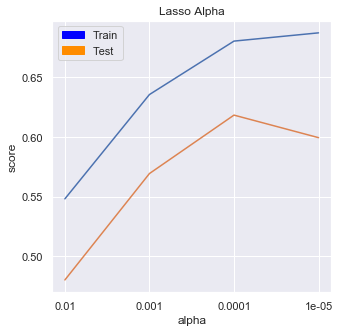

In [433]:
import matplotlib.patches as mpatches

n = len(alphas)
a = np.arange(n)
blue_patch = mpatches.Patch(color='blue', label='Train')
orange_patch = mpatches.Patch(color='darkorange', label='Test')

train_line = plt.plot(a, train_score) #blue
test_line = plt.plot(a, test_score) #orange
plt.xticks(a, alphas)
plt.legend(handles=[blue_patch, orange_patch], loc=0)
plt.title('Lasso Alpha')
plt.xlabel('alpha')
plt.ylabel('score')
plt.show()

In [434]:
a=0.0001
lasso01 = Lasso(alpha=a, max_iter=10e5)
lasso01.fit(X_train, y_train)

train_score = lasso01.score(X_train, y_train)
test_score = lasso01.score(X_test, y_test)
coeff_used = np.sum(lasso01.coef_!=0)

print('Training score for alpha=',a,':',  round(train_score, 4))
print('Test score for alpha=',a,':', round(test_score, 4))
print('number of features for alpha=',a,':', coeff_used)
print('')

Training score for alpha= 0.0001 : 0.6804
Test score for alpha= 0.0001 : 0.6183
number of features for alpha= 0.0001 : 657



In [435]:
# create train/test/holdout sets for prediction 2016,17,18+
X_train_lasso_coef = dummy[(dummy['Release_Date'].dt.year <= 2016)]  # 16583 90%

X_train_lasso_coef = X_train_lasso_coef.drop(['Name', 'Global_Sales', 'Release_Date'], axis=1)

# view list of variables with their weights
columns = X_train_lasso_coef.columns
d = {'Columns':columns, 'Coefficient':lasso01.coef_}
coefs = pd.DataFrame(data=d)
coefs

coefs = coefs[(coefs['Coefficient'] != 0)]
coefs = coefs.sort_values('Coefficient', ascending=False)
coefs.head()

,Columns,Coefficient
614,Publisher_RedOctane,2.814575
474,Publisher_Microsoft Game Studios,2.120221
475,Publisher_Microsoft Studios,2.101207
519,Publisher_Nintendo,1.973777
1099,Developer_Polyphony Digital,1.973378


### Statsmodel LR

In [436]:
# Create a string for all variables from Lasso with appropriate Q('') where needed to copy into ols formula

# Fix to work with 's in variables Q('Developer_Traveller's Tales') by adding \\ before the ' 
variables = coefs.Columns
varnames = "~"
for i in variables:
    if ' ' not in i and '-' not in i and '/' not in i and '.' not in i:
        varnames += " + " + i
#    elif "'" in i:                   
#        varnames += " + " + "Q('" + "\\" + i + "')"
    else:
        varnames += " + " + "Q('"  + i +  "')"

varnames

"~ + Publisher_RedOctane + Q('Publisher_Microsoft Game Studios') + Q('Publisher_Microsoft Studios') + Publisher_Nintendo + Q('Developer_Polyphony Digital') + Publisher_Rare + Q('Developer_Naughty Dog') + Publisher_Tengen + Publisher_Valve + Q('Publisher_Rockstar Games') + Q('Publisher_989 Studios') + Q('Developer_Infinity Ward') + Q('Publisher_mixi, Inc') + Publisher_Mojang + Publisher_LucasArts + Q('Publisher_Sony Computer Entertainment America') + Q('Publisher_Valve Corporation') + Q('Publisher_Arena Entertainment') + Q('Developer_Game Freak') + Q('Developer_Rockstar North') + Q('Developer_Codemasters Birmingham') + Q('Publisher_Ultra Games') + Publisher_Enix + Publisher_Jorudan + Q('Publisher_Electronic Arts') + Publisher_Microsoft + Q('Publisher_EA Sports') + Q('Publisher_Bethesda Softworks') + Q('Publisher_Hasbro Interactive') + Q('Developer_Clap Hanz') + Q('Publisher_Disney Interactive Studios') + Q('Developer_Nintendo EAD') + Developer_Bungie + Q('Publisher_Blizzard Entertainmen

In [437]:
# adjust train/test/holdout  (re-making with global sales and release_date columns)
X_train = dummy[(dummy['Release_Date'].dt.year <= 2016)]  # 16583 90%
X_test = dummy[(dummy['Release_Date'].dt.year == 2017)]   # 690 4%
X_holdout = dummy[(dummy['Release_Date'].dt.year >= 2018)] # 1249 6%

# Create x and y datasets
# TRAIN 1985-2016
X_train = X_train.drop(['Name'], axis=1)

# TEST 2017
X_test = X_test.drop(['Name'], axis=1)

# HOLDOUT 2018+
X_hold = X_holdout.drop(['Name'], axis=1)

In [438]:
# statsmodel LR vs train
# Mix of lasso pre and post scaling:
modela = ols("Global_Sales ~ Publisher_Nintendo + Q('Publisher_Microsoft Game Studios') + Q('Publisher_Rockstar Games') \
+ Q('Publisher_EA Sports') + Q('Publisher_Electronic Arts') + Publisher_LucasArts + Q('Publisher_Microsoft Studios') \
+ Q('Publisher_Square Enix') + Q('Developer_Nintendo EAD') + Q('Developer_Game Freak') + Genre_Shooter \
+ Q('Publisher_Sony Computer Entertainment') + Platform_Wii + Platform_PS4 + Month_Nov + Platform_X360 + Platform_PS3 \
+ Month_Oct + Q('Genre_Role-Playing') + Publisher_Activision + Order + Platform_XB \
+ Release_Year + Month_Dec + Developer_Indie + Platform_PSP + Developer_Unknown + Genre_Adventure + Company_Nintendo \
+ Publisher_Nintendo*Platform_Wii + Q('Developer_Nintendo EAD')*Platform_Wii + Platform_NS \
+ Platform_NS*Q('Developer_Nintendo EAD')", X_train).fit()

In [439]:
# scaled
modelb = ols("Global_Sales ~ Publisher_Nintendo + Q('Publisher_EA Sports') + Q('Publisher_Electronic Arts') + Publisher_THQ \
+ Publisher_Activision + Q('Publisher_Sony Computer Entertainment') + Publisher_Ubisoft + Platform_PS4 + Q('Developer_Traveller\\'s Tales') \
+ Platform_PS3 + Q('Publisher_Disney Interactive Studios') + Q('Publisher_Square Enix') + Q('Genre_Role-Playing') \
+ Month_Oct + Platform_X360 + Genre_Shooter + Publisher_Sega + Month_Nov + Publisher_Capcom + Genre_Platform + Release_Month \
+ Genre_Fighting + Order + Month_Jul + Release_Day + Genre_Strategy + Month_Apr + Release_Year + Q('Publisher_Idea Factory') \
+ Genre_Puzzle + Genre_Misc + Month_Dec + Platform_XB + Platform_PSV + Company_Nintendo + Developer_Indie + Genre_Adventure \
+ Platform_GBA + Platform_DS + Developer_Unknown + Platform_PSP + Regional_Sales_NA + Regional_Sales_JP + Regional_Sales_PAL \
+ Regional_Sales_Other + Regional_Sales_Similar + Regional_Sales_None", X_train).fit()

In [440]:
#base
modelc = ols("Global_Sales ~ Q('Developer_Nintendo EAD') + Publisher_Nintendo + Q('Developer_Game Freak') \
+ Q('Publisher_Rockstar Games') + Genre_Shooter + Q('Publisher_Sony Computer Entertainment') + Platform_Wii \
+ Platform_PS4 + Month_Nov + Q('Publisher_Electronic Arts') + Q('Publisher_EA Sports') + Platform_X360 + Platform_PS3 \
+ Month_Oct + Q('Genre_Role-Playing') + Release_Month + Publisher_Activision + Order + Release_Day + Platform_XB + Genre_Misc \
+ Release_Year + Month_Dec + Developer_Indie + Platform_PSP + Developer_Unknown + Genre_Adventure + Company_Nintendo", X_train).fit()

In [441]:
modeld = ols("Global_Sales ~ Publisher_Nintendo + Q('Publisher_Rockstar Games') + Q('Publisher_Microsoft Game Studios') + Q('Publisher_EA Sports') + Q('Publisher_Microsoft Studios') \
+ Publisher_LucasArts + Q('Publisher_Electronic Arts') + Q('Publisher_Disney Interactive Studios') + Publisher_RedOctane + Publisher_THQ + Q('Publisher_Warner Bros. Interactive') \
+ Q('Publisher_Warner Bros. Interactive Entertainment') + Q('Developer_Polyphony Digital') + Q('Publisher_Square Enix') + Q('Publisher_EA Sports BIG') + Q('Developer_Nintendo EAD') \
+ Q('Developer_Game Freak') + Q('Developer_Naughty Dog') + Publisher_Activision + Q('Publisher_2K Games') + Q('Publisher_Bethesda Softworks') + Q('Publisher_Sony Computer Entertainment') \
+ Q('Publisher_MTV Games') + Publisher_Ubisoft + Q('Publisher_989 Studios') + Q('Publisher_2K Sports') + Q('Publisher_Konami Digital Entertainment') + Publisher_Microsoft + Publisher_Sega \
+ Q('Developer_Infinity Ward') + Q('Publisher_Vivendi Games') + Developer_SquareSoft + Publisher_Capcom + Platform_PS4 + Publisher_Namco + Q('Publisher_Buena Vista') \
+ Q('Publisher_VU Games') + Q('Publisher_2K Play') + Developer_Treyarch + Publisher_Natsume + Publisher_Majesco + Q('Developer_Vicarious Visions') + Q('Publisher_Xseed Games') \
+ Q('Publisher_Take-Two Interactive') + Publisher_Konami + Q('Developer_Rockstar North') + Publisher_Atari + Q('Publisher_Sony Computer Entertainment America') + Q('Developer_Neversoft Entertainment') \
+ Platform_XOne + Q('Publisher_Hasbro Interactive') + Publisher_Enix + Q('Publisher_Eidos Interactive') + Q('Publisher_Midway Games') + Q('Publisher_Sierra Entertainment') + Publisher_Codemasters \
+ Q('Developer_Team Ninja') + Q('Publisher_Namco Bandai') + Q('Developer_Omega Force') + Q('Developer_Sonic Team') + Q('Developer_Level 5') + Q('Developer_Visual Concepts') \
+ Q('Developer_Ubisoft Montreal') + Q('Publisher_Acclaim Entertainment') + Q('Publisher_Namco Bandai Games') + Q('Developer_Majesco Games') + Platform_PS3 + Platform_X360 + Q('Publisher_Gotham Games') \
+ Q('Developer_EA Black Box') + Q('Developer_Konami Computer Entertainment Tokyo') + Platform_3DS + Q('Publisher_Universal Interactive') + Q('Genre_Role-Playing') + Q('Developer_EA Tiburon') \
+ Genre_Fighting + Q('Genre_Action-Adventure') + Q('Developer_Ubisoft Paris') + Q('Developer_Crystal Dynamics') + Publisher_Atlus + Genre_Shooter + Q('Publisher_NIS America') \
+ Q('Publisher_Crave Entertainment') + Month_Oct + Q('Publisher_Hudson Soft') + Platform_GB + Developer_Namco + Publisher_Infogrames + Platform_Wii + Handheld_No + Company_Sony \
+ Publisher_Bandai + Q('Developer_EA Canada') + Publisher_Banpresto + Genre_Platform + Month_Nov + Publisher_Square + Q('Developer_Digital Eclipse') + Developer_CyberConnect2 + Publisher_Destineer \
+ Q('Developer_Radical Entertainment') + Month_May + Developer_Banpresto + Q('Developer_Black Lantern Studios') + Platform_PS2 + Q('Publisher_TDK Mediactive') + Month_Mar \
+ Q('Developer_EA Redwood Shores') + Q('Developer_Griptonite Games') + Release_Month + Q('Publisher_Aksys Games') + Q('Publisher_Destination Software, Inc') + Company_Microsoft + Order \
+ Handheld_Yes + Developer_Various + Release_Day + Month_Jan + Publisher_Agetec + Q('Publisher_Metro 3D') + Publisher_Alchemist + Q('Publisher_Avanquest Software') + Q('Developer_Koei Tecmo Games') \
+ Q('Publisher_Conspiracy Entertainment') + Company_Nintendo + Month_Aug + Q('Developer_Frontier Developments') + Platform_WiiU + Publisher_KOEI + Genre_Racing + Q('Developer_Arc System Works') \
+ Genre_Sports + Month_Jul + Q('Developer_Sony Computer Entertainment') + Release_Year + Q('Developer_Big Ant Studios') + Q('Developer_SNK Playmore Corporation') + Month_Apr + Genre_Misc \
+ Q('Developer_The Sims Studio') + Genre_Strategy + Q('Developer_Left Field Productions') + Developer_Eighting + Company_Sega + Developer_Eutechnyx + Publisher_D3Publisher + Developer_Konami \
+ Developer_Koei + Developer_THQ + Q('Publisher_Focus Home Interactive') + Month_Dec + Publisher_Quinrose + Genre_Puzzle + Q('Publisher_Idea Factory') + Publisher_Mindscape + Publisher_MTO \
+ Q('Developer_Data Design Interactive') + Developer_Indie + Q('Publisher_Bigben Interactive') + Q('Publisher_SNK Playmore') + Platform_DS + Q('Publisher_Black Bean Games') \
+ Q('Publisher_Arc System Works') + Genre_Adventure + Q('Publisher_Takara Tomy') + Developer_Ubisoft + Publisher_Unknown + Publisher_Kemco + Platform_PSP + Publisher_Jaleco \
+ Q('Developer_Behaviour Interactive') + Developer_Activision + Publisher_Prototype + Q('Developer_Blade Interactive') + Q('Publisher_Rising Star') + Platform_XB + Developer_Nintendo \
+ Platform_GC + Developer_Unknown + Q('Publisher_Nippon Ichi Software') + Q('Publisher_Marvelous Interactive') + Platform_GBA + Q('Publisher_Zushi Games') + Q('Developer_Idea Factory') \
+ Developer_Success + Q('Developer_Taito Corporation') + Publisher_CyberFront + Q('Publisher_Oxygen Interactive') + Q('Publisher_Midas Interactive Entertainment') \
+ Q('Developer_Electronic Arts') + Publisher_5pb + Q('Developer_Little Orbit') + Q('Publisher_System Soft') + Regional_Sales_NA + Regional_Sales_JP + Regional_Sales_PAL \
+ Regional_Sales_Other + Regional_Sales_Similar + Regional_Sales_None", X_train).fit()





In [442]:
modele = ols("Global_Sales ~ Publisher_Nintendo + Q('Publisher_Microsoft Game Studios') + Q('Publisher_Rockstar Games') + Q('Publisher_Microsoft Studios') + Publisher_LucasArts \
+ Q('Publisher_EA Sports') + Q('Publisher_Electronic Arts') + Q('Developer_Nintendo EAD') + Q('Publisher_Warner Bros. Interactive Entertainment') + Q('Publisher_Square Enix') \
+ Publisher_RedOctane + Q('Publisher_Disney Interactive Studios') + Regional_Sales_Similar + Q('Developer_Naughty Dog') + Q('Developer_Infinity Ward') + Q('Publisher_Sony Computer Entertainment') \
+ Developer_SquareSoft + Publisher_THQ + Q('Publisher_Bethesda Softworks') + Publisher_Enix + Q('Developer_Polyphony Digital') + Q('Publisher_Warner Bros. Interactive') + Developer_Treyarch \
+ Q('Publisher_2K Games') + Regional_Sales_Other + Publisher_Activision + Q('Developer_Game Freak') + Q('Developer_Neversoft Entertainment') + Publisher_Sega + Q('Publisher_989 Studios') \
+ Q('Developer_Ubisoft Montreal') + Q('Publisher_Konami Digital Entertainment') + Q('Publisher_EA Sports BIG') + Q('Developer_Omega Force') + Publisher_Microsoft \
+ Platform_PS4 + Publisher_Capcom + Q('Developer_Vicarious Visions') + Publisher_Ubisoft + Q('Developer_Level 5') + Q('Developer_Rockstar North') + Publisher_Namco + Q('Developer_Diamond Head') \
+ Q('Publisher_Namco Bandai') + Q('Publisher_MTV Games') + Q('Developer_Visual Concepts') + Q('Publisher_Namco Bandai Games') + Developer_Namco + Q('Publisher_2K Sports') + Publisher_Banpresto \
+ Q('Developer_EA Tiburon') + Q('Publisher_VU Games') + Q('Publisher_Sony Computer Entertainment America') + Q('Developer_Sonic Team') + Publisher_Square + Q('Developer_EA Black Box') \
+ Platform_XOne + Publisher_Konami + Q('Publisher_Eidos Interactive') + Q('Genre_Role-Playing') + Platform_PS3 + Q('Developer_Konami Computer Entertainment Tokyo') + Publisher_Atari \
+ Q('Publisher_Buena Vista') + Q('Developer_EA Canada') + Q('Developer_Ubisoft Paris') + Publisher_Bandai + Publisher_Codemasters + Q('Publisher_Vivendi Games') \
+ Q('Publisher_Hudson Soft') + Regional_Sales_NA + Platform_X360 + Q('Publisher_Midway Games') + Genre_Fighting + Platform_GB + Q('Publisher_Level 5') + Q('Publisher_Take-Two Interactive') \
+ Q('Publisher_Xseed Games') + Q('Publisher_Hasbro Interactive') + Q('Publisher_2K Play') + Publisher_Majesco + Genre_Shooter + Q('Developer_PawaPuro Production') + Month_Oct \
+ Genre_Music + Q('Publisher_Sierra Entertainment') + Q('Publisher_Acclaim Entertainment') + Q('Genre_Action-Adventure') + Q('Developer_EA Redwood Shores') + Developer_Banpresto \
+ Publisher_Natsume + Month_Nov + Platform_3DS + Developer_Capcom + Q('Developer_Radical Entertainment') + Genre_Platform + Q('Developer_Codemasters Birmingham') + Q('Developer_Team Ninja') \
+ Handheld_No + Platform_SNES + Q('Developer_Crystal Dynamics') + Month_May + Platform_Wii + Q('Developer_Majesco Games') + Month_Feb + Developer_Sega + Developer_ChunSoft + Release_Month \
+ Month_Mar + Q('Developer_Ubisoft Montpellier') + Company_Microsoft + Order + Handheld_Yes + Release_Day + Month_Jun + Genre_Action + Genre_Misc + Q('Publisher_Crave Entertainment') \
+ Publisher_Agetec + Q('Developer_SNK Playmore Corporation') + Developer_Koei + Genre_Sports + Q('Publisher_XS Games') + Regional_Sales_PAL + Developer_Success + Month_Jul + Publisher_Titus \
+ Q('Developer_Treasure Co., Ltd.') + Q('Developer_Behaviour Interactive') + Publisher_Quinrose + Month_Apr + Platform_N64 + Q('Publisher_Valcon Games') + Platform_PS2 \
+ Q('Developer_Blade Interactive') + Q('Publisher_DSI Games') + Publisher_Destineer + Publisher_KOEI + Publisher_Prototype + Q('Publisher_Nippon Ichi Software') \
+ Q('Developer_Arc System Works') + Release_Year + Genre_Racing + Q('Publisher_Idea Factory') + Q('Developer_Data Design Interactive') + Developer_Ubisoft + Month_Dec \
+ Publisher_Unknown + Genre_Strategy + Q('Publisher_Storm City Games') + Q('Developer_Left Field Productions') + Developer_Indie + Platform_DS + Q('Publisher_Marvelous Interactive') \
+ Publisher_Jaleco + Genre_Adventure + Developer_THQ + Publisher_Psygnosis + Q('Developer_Idea Factory') + Platform_PSP + Genre_Puzzle + Platform_WiiU + Developer_Nintendo \
+ Q('Developer_Big Ant Studios') + Q('Developer_Electronic Arts') + Q('Publisher_Zoo Games') + Q('Publisher_DreamCatcher Interactive') + Q('Publisher_Conspiracy Entertainment') \
+ Q('Publisher_SNK Playmore') + Q('Developer_Taito Corporation') + Q('Publisher_UFO Interactive') + Q('Developer_Little Orbit') + Developer_Unknown + Developer_Activision + Publisher_5pb \
+ Platform_GBA + Regional_Sales_JP + Regional_Sales_None + Platform_XB + Platform_GC", X_train).fit()

In [443]:
# Predictions
pred_a = modela.predict(X_test)
pred_b = modelb.predict(X_test)
pred_c = modelc.predict(X_test)
pred_d = modeld.predict(X_test)
pred_e = modele.predict(X_test)

from sklearn.metrics import r2_score

print('Model a Training score:', round(modela.rsquared_adj, 3), 'and Testing score:', round(r2_score(y_test, pred_a), 3))
print('Model b Training score:', round(modelb.rsquared_adj, 3), 'and Testing score:', round(r2_score(y_test, pred_b), 3))
print('Model c Training score:', round(modelc.rsquared_adj, 3), 'and Testing score:', round(r2_score(y_test, pred_c), 3))
print('Model d Training score:', round(modeld.rsquared_adj, 3), 'and Testing score:', round(r2_score(y_test, pred_d), 3))
print('Model e Training score:', round(modele.rsquared_adj, 3), 'and Testing score:', round(r2_score(y_test, pred_e), 3))

Model a Training score: 0.263 and Testing score: 0.221
Model b Training score: 0.576 and Testing score: 0.51
Model c Training score: 0.251 and Testing score: 0.217
Model d Training score: 0.646 and Testing score: 0.582
Model e Training score: 0.647 and Testing score: 0.575


In [444]:
# if using scaling, check R^2 reversing the log
from sklearn.metrics import r2_score

dollar_pred_a = np.exp(pred_a) - 0.001     # - 0.001 is for adjustment before scaling to handle 0's
dollar_pred_b = np.exp(pred_b) - 0.001
dollar_pred_c = np.exp(pred_c) - 0.001
dollar_pred_d = np.exp(pred_d) - 0.001
dollar_pred_e = np.exp(pred_e) - 0.001

Y_test_dollar = np.exp(y_test) - 0.001


# R^2 after undoing normalization with exp()
print('Model a Test score after undoing log:', round(r2_score(Y_test_dollar, dollar_pred_a), 3))
print('Model b Test score after undoing log:', round(r2_score(Y_test_dollar, dollar_pred_b), 3))
print('Model c Test score after undoing log:', round(r2_score(Y_test_dollar, dollar_pred_c), 3))
print('Model d Test score after undoing log:', round(r2_score(Y_test_dollar, dollar_pred_d), 3))
print('Model e Test score after undoing log:', round(r2_score(Y_test_dollar, dollar_pred_e), 3))

Model a Test score after undoing log: 0.1
Model b Test score after undoing log: 0.126
Model c Test score after undoing log: 0.108
Model d Test score after undoing log: 0.203
Model e Test score after undoing log: 0.197


In [445]:
regressor_pred = modeld.predict(X_test)
regressor_pred_hold = modeld.predict(X_hold)

## Random Forest Regressor

In [446]:
# adjust train/test/holdout  (re-making with global sales and release_date columns)
X_train = dummy[(dummy['Release_Date'].dt.year <= 2016)]  # 16583 90%
X_test = dummy[(dummy['Release_Date'].dt.year == 2017)]   # 690 4%
X_holdout = dummy[(dummy['Release_Date'].dt.year >= 2018)] # 1249 6%

# Create x and y datasets
# TRAIN 1985-2016
y_train = X_train[['Global_Sales']]
X_train = X_train.drop(['Name', 'Global_Sales', 'Release_Date'], axis=1)

# TEST 2017
y_test = X_test[['Global_Sales']]
X_test = X_test.drop(['Name', 'Global_Sales', 'Release_Date'], axis=1)

# HOLDOUT 2018+
y_hold = X_holdout[['Global_Sales']]
X_hold = X_holdout.drop(['Name', 'Global_Sales', 'Release_Date'], axis=1)

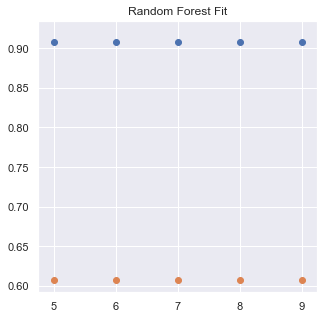

In [447]:
from sklearn.ensemble import RandomForestRegressor
y_tree_train = y_train.Global_Sales
y_tree_test = y_test.Global_Sales
rsqd_train = [] 
rsqd_test = []
depth = []

# for loop to loop over various parameters to improve model performance
for i in range(5, 10, 1):
    forest = RandomForestRegressor(n_estimators=14, max_depth=45, min_samples_split=6, min_samples_leaf=1,
                                    max_features="auto", random_state=42) # use i to adjuest hyperperameters
    forest.fit(X_train, y_tree_train)
    rsqd_train.append(forest.score(X_train, y_tree_train))
    rsqd_test.append(forest.score(X_test, y_tree_test))
    depth.append(i)
    

plt.figure()
plt.scatter(depth, rsqd_train) # blue
plt.scatter(depth, rsqd_test) # orange
plt.title('Random Forest Fit')
plt.show()

In [448]:
print('R^2 for forest train:', round(forest.score(X_train, y_train), 3))
print('R^2 for forest test:', round(forest.score(X_test, y_test), 3))

R^2 for forest train: 0.908
R^2 for forest test: 0.608


In [449]:
forest_pred = forest.predict(X_test)
forest_pred_hold = forest.predict(X_hold)

In [450]:
rsqd = []
regressor_coeff = []

for i in np.arange(0.1, 1.1, 0.1):
    ensemble = (i*regressor_pred + (1-i)*forest_pred)
    regressor_coeff.append(i)
    rsqd.append(r2_score(y_test, ensemble))
    r2 = r2_score(y_test, ensemble)
    print('R^2 score:', np.round(r2, 4))
    
# It would seem that a 40-60 split is best for data

R^2 score: 0.6207
R^2 score: 0.6304
R^2 score: 0.6365
R^2 score: 0.6392
R^2 score: 0.6384
R^2 score: 0.634
R^2 score: 0.6262
R^2 score: 0.615
R^2 score: 0.6002
R^2 score: 0.5819


In [451]:
# create graph values
ensemble = (0.4*regressor_pred + 0.6*forest_pred)
r2 = r2_score(y_test, ensemble)
print('R^2 score:', np.round(r2, 4))

R^2 score: 0.6392


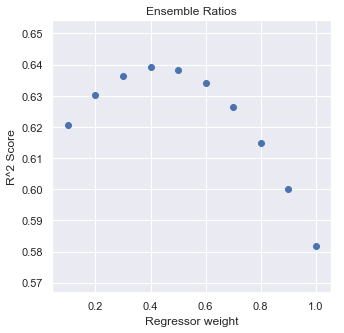

In [452]:
# graph for ensemble ratios
plt.figure()
plt.scatter(regressor_coeff, rsqd)
plt.xlabel('Regressor weight')
plt.ylabel('R^2 Score')
plt.title('Ensemble Ratios')
plt.show()

## Features

In [453]:
# Linear Regression
regression_importance = modeld.params
means = X_train.mean()

In [454]:
# Random Forest
features_forest = X_train.columns
forest_importance = forest.feature_importances_

# Build forest importance DF
features = pd.DataFrame(forest_importance,
                       index=features_forest,
                       columns=['Forest Importance']).sort_values('Forest Importance', ascending=False)

In [455]:
features.head(10) # most influential features

,Forest Importance
Regional_Sales_None,0.337972
Order,0.105261
Regional_Sales_JP,0.079176
Regional_Sales_Similar,0.038563
Publisher_Nintendo,0.032418
Release_Day,0.031640
Handheld_No,0.017192
Release_Month,0.017038
Publisher_EA Sports,0.008919
Publisher_Electronic Arts,0.008880


## Test Check

In [456]:
dollar_ensemble = np.exp(ensemble) - 0.001

test_info = clean_df[(clean_df['Release_Date'].dt.year == 2017)]   # 690 4%
holdout_info = clean_df[(clean_df['Release_Date'].dt.year >= 2018)] # 1249 6%

df = pd.DataFrame({'ensemble':dollar_ensemble})
df = pd.concat([df, test_info], axis=1)
df

,ensemble,Name,Platform,Genre,Publisher,Developer,Global_Sales,Release_Date,Release_Year,Release_Month,Release_Day,Month,Company,Order,Handheld,Regional_Sales
26,0.197571,Horizon: Zero Dawn,PS4,Action,Sony Interactive Entertainment,Indie,5.18,2017-02-28,2017,2,28,Feb,Sony,16652,No,Similar
50,0.982789,Assassin's Creed Origins,PS4,Action,Ubisoft,Ubisoft Montreal,3.88,2017-10-27,2017,10,27,Oct,Sony,17148,No,PAL
85,0.539542,Resident Evil VII: Biohazard,PS4,Action,Capcom,Capcom,2.92,2017-01-24,2017,1,24,Jan,Sony,16603,No,Similar
108,0.396211,Assassin's Creed Origins,XOne,Action,Ubisoft,Ubisoft Montreal,2.36,2017-10-27,2017,10,27,Oct,Microsoft,17147,No,NA
121,0.317073,Uncharted: The Lost Legacy,PS4,Action,Sony Interactive Entertainment,Naughty Dog,2.10,2017-08-22,2017,8,22,Aug,Sony,16943,No,PAL
143,0.929134,Middle-Earth: Shadow of War,PS4,Action,Warner Bros. Interactive Entertainment,Monolith Productions,1.85,2017-10-10,2017,10,10,Oct,Sony,17080,No,Similar
163,0.157458,Monster Hunter Double Cross,3DS,Action,Capcom,Capcom,1.67,2017-03-18,2017,3,18,Mar,Nintendo,16688,Yes,JP
166,1.113560,For Honor,PS4,Action,Ubisoft,Ubisoft Montreal,1.64,2017-02-14,2017,2,14,Feb,Sony,16632,No,Similar
290,0.274338,Middle-Earth: Shadow of War,XOne,Action,Warner Bros. Interactive Entertainment,Monolith Productions,1.03,2017-10-10,2017,10,10,Oct,Microsoft,17074,No,NA
291,0.538740,Nioh,PS4,Action,Sony Interactive Entertainment,Koei Tecmo Games,1.03,2017-02-07,2017,2,7,Feb,Sony,16627,No,Similar


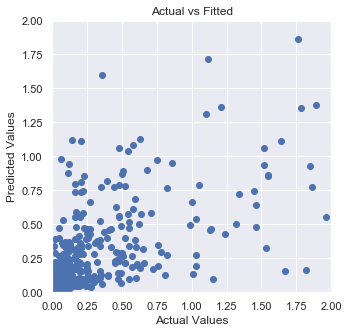

In [457]:
plt.scatter(df.Global_Sales, df.ensemble)
plt.xlim(0,2)
plt.ylim(0,2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Fitted');

The ensemble model appears to handle the lower valued predictions better, which are more closely cluttered around the 45 degree line vs values greater than 1 where the predictions are generally below the true value.

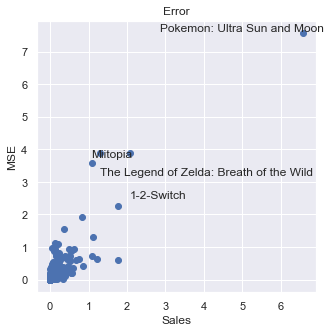

In [458]:
mse = np.sqrt(((df.ensemble**2)-(df.Global_Sales**2)))

y = [7.62, 3.74, 3.20, 2.5]
z = [2.87, 1.08, 1.31, 2.07]
n = ['Pokemon: Ultra Sun and Moon', 'Miitopia', 'The Legend of Zelda: Breath of the Wild', '1-2-Switch']

fig, ax = plt.subplots()
plt.scatter(df.Global_Sales, mse)
plt.xlabel('Sales')
plt.ylabel('MSE')
plt.title('Error')

for i, txt in enumerate(n):
    ax.annotate(txt, (z[i], y[i]), )

In [459]:
cols = df.columns.tolist()
cols = ['ensemble',
 'Global_Sales', # reorder to place global sales next to ensemble predictions
 'Name',
 'Platform',
 'Genre',
 'Publisher',
 'Developer',
 'Release_Date',
 'Release_Year',
 'Release_Month',
 'Release_Day',
 'Month',
 'Company',
 'Order',
 'Handheld']

df = df[cols]

In [460]:
top20pred = df.sort_values('ensemble', ascending=False).head(20)
top20actual = df.sort_values('Global_Sales', ascending=False).head(20)

# Join the two dataframes to see which was predicted to be a top seller accurately
predicted = pd.merge(top20pred, top20actual, how='inner', on='Name') 
predicted 

#r2_score()

,ensemble_x,Global_Sales_x,Name,Platform_x,Genre_x,Publisher_x,Developer_x,Release_Date_x,Release_Year_x,Release_Month_x,...,Publisher_y,Developer_y,Release_Date_y,Release_Year_y,Release_Month_y,Release_Day_y,Month_y,Company_y,Order_y,Handheld_y
0,10.020056,6.57,Pokémon: Ultra Sun and Ultra Moon,3DS,Role-Playing,Nintendo,Game Freak,2017-11-17,2017,11,...,Nintendo,Game Freak,2017-11-17,2017,11,17,Nov,Nintendo,17211,Yes
1,5.555111,9.21,Mario Kart 8 Deluxe,NS,Racing,Nintendo,Nintendo EAD,2017-04-28,2017,4,...,Nintendo,Nintendo EAD,2017-04-28,2017,4,28,Apr,Nintendo,16779,Yes
2,4.653680,7.96,The Legend of Zelda: Breath of the Wild,NS,Action-Adventure,Nintendo,Nintendo EAD,2017-03-03,2017,3,...,Nintendo,Nintendo EAD,2017-03-03,2017,3,3,Mar,Nintendo,16666,Yes
3,4.108715,1.31,The Legend of Zelda: Breath of the Wild,WiiU,Action-Adventure,Nintendo,Nintendo EAD,2017-03-03,2017,3,...,Nintendo,Nintendo EAD,2017-03-03,2017,3,3,Mar,Nintendo,16666,Yes
4,3.522701,5.95,Splatoon 2,NS,Shooter,Nintendo,Nintendo EAD,2017-07-21,2017,7,...,Nintendo,Nintendo EAD,2017-07-21,2017,7,21,Jul,Nintendo,16894,Yes
5,1.861759,1.76,Star Wars Battlefront II (2017),XOne,Shooter,Electronic Arts,EA DICE,2017-11-17,2017,11,...,Electronic Arts,EA DICE,2017-11-17,2017,11,17,Nov,Sony,17212,No
6,1.464060,4.18,Star Wars Battlefront II (2017),PS4,Shooter,Electronic Arts,EA DICE,2017-11-17,2017,11,...,Electronic Arts,EA DICE,2017-11-17,2017,11,17,Nov,Sony,17212,No
7,1.327779,13.05,Call of Duty: WWII,PS4,Shooter,Activision,Indie,2017-11-03,2017,11,...,Activision,Indie,2017-11-03,2017,11,3,Nov,Sony,17163,No
8,1.327779,13.05,Call of Duty: WWII,PS4,Shooter,Activision,Indie,2017-11-03,2017,11,...,Activision,Indie,2017-11-03,2017,11,3,Nov,Microsoft,17161,No


## Combine Training and Test sets to re-fit models and predict Holdout

In [461]:
# For Linear Regression
full_train = dummy[(dummy['Release_Date'].dt.year <= 2017)]
full_train_reg = full_train.drop(['Name'], axis=1)

In [462]:
modeld = ols("Global_Sales ~ Publisher_Nintendo + Q('Publisher_Rockstar Games') + Q('Publisher_Microsoft Game Studios') + Q('Publisher_EA Sports') + Q('Publisher_Microsoft Studios') \
+ Publisher_LucasArts + Q('Publisher_Electronic Arts') + Q('Publisher_Disney Interactive Studios') + Publisher_RedOctane + Publisher_THQ + Q('Publisher_Warner Bros. Interactive') \
+ Q('Publisher_Warner Bros. Interactive Entertainment') + Q('Developer_Polyphony Digital') + Q('Publisher_Square Enix') + Q('Publisher_EA Sports BIG') + Q('Developer_Nintendo EAD') \
+ Q('Developer_Game Freak') + Q('Developer_Naughty Dog') + Publisher_Activision + Q('Publisher_2K Games') + Q('Publisher_Bethesda Softworks') + Q('Publisher_Sony Computer Entertainment') \
+ Q('Publisher_MTV Games') + Publisher_Ubisoft + Q('Publisher_989 Studios') + Q('Publisher_2K Sports') + Q('Publisher_Konami Digital Entertainment') + Publisher_Microsoft + Publisher_Sega \
+ Q('Developer_Infinity Ward') + Q('Publisher_Vivendi Games') + Developer_SquareSoft + Publisher_Capcom + Platform_PS4 + Publisher_Namco + Q('Publisher_Buena Vista') \
+ Q('Publisher_VU Games') + Q('Publisher_2K Play') + Developer_Treyarch + Publisher_Natsume + Publisher_Majesco + Q('Developer_Vicarious Visions') + Q('Publisher_Xseed Games') \
+ Q('Publisher_Take-Two Interactive') + Publisher_Konami + Q('Developer_Rockstar North') + Publisher_Atari + Q('Publisher_Sony Computer Entertainment America') + Q('Developer_Neversoft Entertainment') \
+ Platform_XOne + Q('Publisher_Hasbro Interactive') + Publisher_Enix + Q('Publisher_Eidos Interactive') + Q('Publisher_Midway Games') + Q('Publisher_Sierra Entertainment') + Publisher_Codemasters \
+ Q('Developer_Team Ninja') + Q('Publisher_Namco Bandai') + Q('Developer_Omega Force') + Q('Developer_Sonic Team') + Q('Developer_Level 5') + Q('Developer_Visual Concepts') \
+ Q('Developer_Ubisoft Montreal') + Q('Publisher_Acclaim Entertainment') + Q('Publisher_Namco Bandai Games') + Q('Developer_Majesco Games') + Platform_PS3 + Platform_X360 + Q('Publisher_Gotham Games') \
+ Q('Developer_EA Black Box') + Q('Developer_Konami Computer Entertainment Tokyo') + Platform_3DS + Q('Publisher_Universal Interactive') + Q('Genre_Role-Playing') + Q('Developer_EA Tiburon') \
+ Genre_Fighting + Q('Genre_Action-Adventure') + Q('Developer_Ubisoft Paris') + Q('Developer_Crystal Dynamics') + Publisher_Atlus + Genre_Shooter + Q('Publisher_NIS America') \
+ Q('Publisher_Crave Entertainment') + Month_Oct + Q('Publisher_Hudson Soft') + Platform_GB + Developer_Namco + Publisher_Infogrames + Platform_Wii + Handheld_No + Company_Sony \
+ Publisher_Bandai + Q('Developer_EA Canada') + Publisher_Banpresto + Genre_Platform + Month_Nov + Publisher_Square + Q('Developer_Digital Eclipse') + Developer_CyberConnect2 + Publisher_Destineer \
+ Q('Developer_Radical Entertainment') + Month_May + Developer_Banpresto + Q('Developer_Black Lantern Studios') + Platform_PS2 + Q('Publisher_TDK Mediactive') + Month_Mar \
+ Q('Developer_EA Redwood Shores') + Q('Developer_Griptonite Games') + Release_Month + Q('Publisher_Aksys Games') + Q('Publisher_Destination Software, Inc') + Company_Microsoft + Order \
+ Handheld_Yes + Developer_Various + Release_Day + Month_Jan + Publisher_Agetec + Q('Publisher_Metro 3D') + Publisher_Alchemist + Q('Publisher_Avanquest Software') + Q('Developer_Koei Tecmo Games') \
+ Q('Publisher_Conspiracy Entertainment') + Company_Nintendo + Month_Aug + Q('Developer_Frontier Developments') + Platform_WiiU + Publisher_KOEI + Genre_Racing + Q('Developer_Arc System Works') \
+ Genre_Sports + Month_Jul + Q('Developer_Sony Computer Entertainment') + Release_Year + Q('Developer_Big Ant Studios') + Q('Developer_SNK Playmore Corporation') + Month_Apr + Genre_Misc \
+ Q('Developer_The Sims Studio') + Genre_Strategy + Q('Developer_Left Field Productions') + Developer_Eighting + Company_Sega + Developer_Eutechnyx + Publisher_D3Publisher + Developer_Konami \
+ Developer_Koei + Developer_THQ + Q('Publisher_Focus Home Interactive') + Month_Dec + Publisher_Quinrose + Genre_Puzzle + Q('Publisher_Idea Factory') + Publisher_Mindscape + Publisher_MTO \
+ Q('Developer_Data Design Interactive') + Developer_Indie + Q('Publisher_Bigben Interactive') + Q('Publisher_SNK Playmore') + Platform_DS + Q('Publisher_Black Bean Games') \
+ Q('Publisher_Arc System Works') + Genre_Adventure + Q('Publisher_Takara Tomy') + Developer_Ubisoft + Publisher_Unknown + Publisher_Kemco + Platform_PSP + Publisher_Jaleco \
+ Q('Developer_Behaviour Interactive') + Developer_Activision + Publisher_Prototype + Q('Developer_Blade Interactive') + Q('Publisher_Rising Star') + Platform_XB + Developer_Nintendo \
+ Platform_GC + Developer_Unknown + Q('Publisher_Nippon Ichi Software') + Q('Publisher_Marvelous Interactive') + Platform_GBA + Q('Publisher_Zushi Games') + Q('Developer_Idea Factory') \
+ Developer_Success + Q('Developer_Taito Corporation') + Publisher_CyberFront + Q('Publisher_Oxygen Interactive') + Q('Publisher_Midas Interactive Entertainment') \
+ Q('Developer_Electronic Arts') + Publisher_5pb + Q('Developer_Little Orbit') + Q('Publisher_System Soft') + Regional_Sales_NA + Regional_Sales_JP + Regional_Sales_PAL \
+ Regional_Sales_Other + Regional_Sales_Similar", full_train).fit()

In [463]:
regressor_fullpred = modeld.predict(full_train_reg)

In [464]:
# for random forest
full_y_train = full_train['Global_Sales'] # create y values for fit
full_train = full_train.drop(['Name', 'Global_Sales', 'Release_Date'], axis=1) # drop global sales and release date
forest.fit(full_train, full_y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=45,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=6,
           min_weight_fraction_leaf=0.0, n_estimators=14, n_jobs=None,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [465]:
forest_fullpred = forest.predict(full_train)

## Accuracy

In [466]:
ensemble = (0.4*regressor_fullpred + 0.6*forest_fullpred)
dollar_full_train = np.exp(ensemble) - 0.001

In [467]:
full_train_info = clean_df[(clean_df['Release_Date'].dt.year <= 2017)] # grab entire data fram pre-2018

In [468]:
full_train_pred = pd.DataFrame({'ensemble':dollar_full_train})
full_train_comp = pd.concat([full_train_pred, full_train_info], axis=1) # join prediction to base df

In [469]:
cols=['ensemble','Global_Sales', 'Name', 'Platform', 'Genre', 'Publisher', 'Developer', 'Release_Date', 'Release_Year', 'Release_Month','Release_Day', 'Month', 'Company', 'Order', 'Handheld','Regional_Sales']
full_train_comp = full_train_comp[cols] #move global sales to the front for ease of sight

In [470]:
def rmse(prediction, target):
    return np.sqrt(((prediction - target) ** 2).mean())

print('RMSE of full training:', rmse(full_train_comp.ensemble, full_train_comp.Global_Sales))

RMSE of full training: 0.9901364776772825


## Holdout

In [471]:
regressor_fullpred_holdout = modeld.predict(X_holdout)
forest_fullpred_holdout = forest.predict(X_hold)

In [472]:
ensemble = (0.4*regressor_fullpred_holdout + 0.6*forest_fullpred_holdout)
dollar_ensemble = np.exp(ensemble) - 0.001

holdout = pd.DataFrame({'ensemble':dollar_ensemble})
holdout = pd.concat([holdout, holdout_info], axis=1)

cols = holdout.columns.tolist()

In [473]:
cols = ['ensemble',
 'Global_Sales', # reorder to place global sales next to ensemble predictions
 'Name',
 'Platform',
 'Genre',
 'Publisher',
 'Developer',
 'Release_Date',
 'Release_Year',
 'Release_Month',
 'Release_Day',
 'Month',
 'Company',
 'Order',
 'Handheld',
 'Regional_Sales']

holdout = holdout[cols]

## Final Prediction

In [474]:
holdout_pred = holdout.sort_values('ensemble', ascending=False)
top20pred = holdout_pred.head(20)
top20pred

,ensemble,Global_Sales,Name,Platform,Genre,Publisher,Developer,Release_Date,Release_Year,Release_Month,Release_Day,Month,Company,Order,Handheld,Regional_Sales
23493,7.661951,NaN,"Pokémon: Let's Go, Eevee!",NS,Role-Playing,Nintendo,Game Freak,2018-11-16,2018,11,16,Nov,Nintendo,18237,Yes,Similar
23494,7.661726,NaN,"Pokémon: Let's Go, Pikachu!",NS,Role-Playing,Nintendo,Game Freak,2018-11-16,2018,11,16,Nov,Nintendo,18236,Yes,Similar
5032,6.550944,NaN,Town,NS,Action-Adventure,Nintendo,Game Freak,2019-01-01,2019,1,1,Jan,Nintendo,18353,Yes,Similar
7933,5.521413,NaN,Pokémon Quest,NS,Adventure,Nintendo,Game Freak,2018-05-29,2018,5,29,May,Nintendo,17767,Yes,Similar
7909,2.264159,NaN,Luigi's Mansion,3DS,Adventure,Nintendo,Nintendo EAD,2018-12-10,2018,12,10,Dec,Nintendo,18308,Yes,Similar
4153,2.224056,NaN,The Last of Us: Part II,PS4,Action,Sony Interactive Entertainment,Naughty Dog,2019-12-31,2019,12,31,Dec,Sony,18445,No,Similar
25528,2.132450,NaN,Battlefield V,PS4,Shooter,Electronic Arts,EA DICE,2018-11-20,2018,11,20,Nov,Sony,18244,No,Similar
17573,2.042225,0.42,Captain Toad: Treasure Tracker,NS,Puzzle,Nintendo,Nintendo EAD,2018-07-13,2018,7,13,Jul,Nintendo,17907,Yes,Similar
25535,2.009651,NaN,Call of Duty: Black Ops IIII,PS4,Shooter,Activision,Treyarch,2018-10-12,2018,10,12,Oct,Sony,18127,No,Similar
23441,1.863368,NaN,Fallout 76,PS4,Role-Playing,Bethesda Softworks,Indie,2018-11-14,2018,11,14,Nov,Sony,18231,No,Similar
